In [59]:

# Importing all the required libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
from IPython.display import Image as IMG

In [158]:


## (1) Convert to gray, and threshold
img = cv2.imread("C:\\Users\\lenov\\Downloads\\LED TV mini Data Set\\LED TV mini Data Set\\1.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

## (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

## (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

## (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = img[y:y+h, x:x+w]
cv2.imwrite("1.png", dst)

True

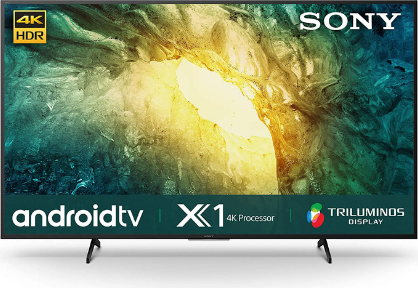

In [159]:

display(Image.open("1.png"))

In [191]:
Image1= Image.open("C:\\Users\\lenov\\Downloads\\zane.jpg")
Image1copy = Image1.copy()
Image2 = Image.open("1.png")
Image2copy = Image2.copy()
Image1copy.paste(Image2copy, (60, 150))
Image1copy.save('g.png')

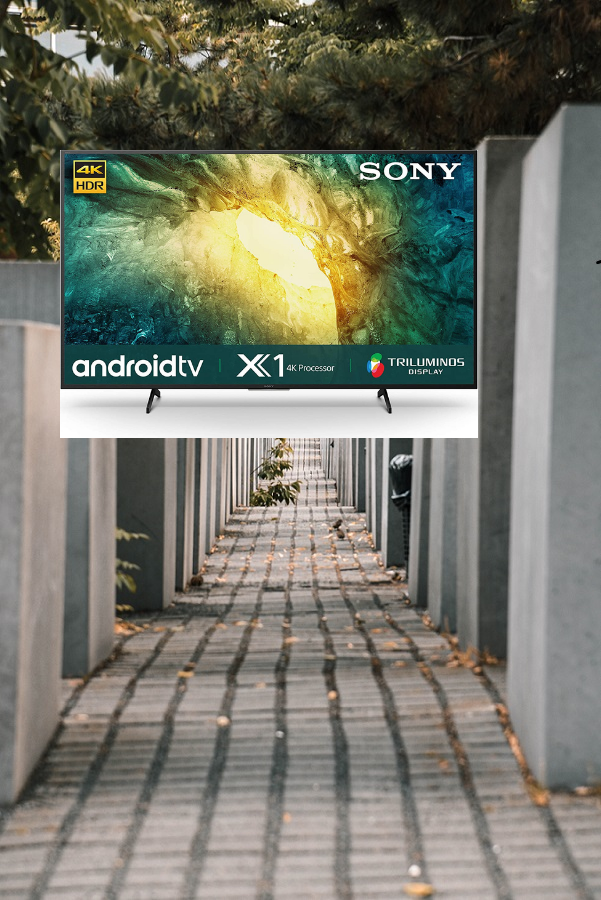

In [223]:
display(Image.open("g.png"))

In [225]:

import tensorflow.compat.v1 as tf

In [226]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
    # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef().FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)
    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        print(width, height)
        print("Resize Ratio - {}".format(resize_ratio))
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        print(target_size)
        # target_size = (width, height)
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [227]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [228]:
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [229]:
def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

In [230]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [231]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [232]:
def run_visualization():
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(IMAGE_NAME)
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return

    print('running deeplab on image')
    resized_im, seg_map = MODEL.run(original_im)
    vis_segmentation(resized_im, seg_map)
    return resized_im, seg_map

running deeplab on image
601 900
Resize Ratio - 0.57
(342, 513)


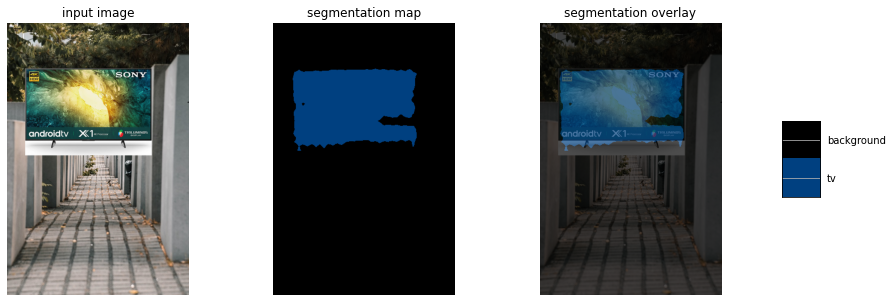

In [234]:
IMAGE_NAME = 'g.png'
resized_im, seg_map = run_visualization()

In [211]:
LABEL_NAMES

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

In [212]:
print(type(resized_im))
numpy_image = np.array(resized_im)

<class 'PIL.Image.Image'>


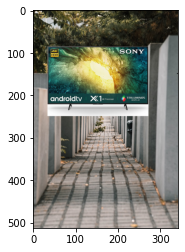

In [213]:
plt.imshow(numpy_image)

In [199]:
person_not_person_mapping = deepcopy(numpy_image)
person_not_person_mapping[seg_map != 20] = 0
person_not_person_mapping[seg_map == 20] = 255
# Seperating background & foreground classes using Segmap.
# Replacing the pixel intensity values to 0 where the car class is not found in segmen
# Please note that if you have image with any other class then the class label to different value ex: for person it will be 15, for bird it will be 3.

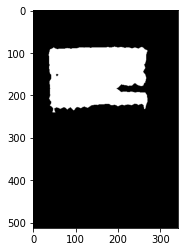

In [200]:
plt.imshow(person_not_person_mapping)
# Ploting the mapped image.

In [201]:
np.unique(person_not_person_mapping)
# checking the unique values of pixel instensity after changes.

array([  0, 255], dtype=uint8)

In [202]:
orig_imginal = Image.open(IMAGE_NAME)
orig_imginal = np.array(orig_imginal)
# Reading the original image.
# Converting the image to an numpy array.
# Checking the dimensions of the original image.

In [203]:
orig_imginal.shape

(900, 601, 3)

In [204]:
mapping_resized = cv2.resize(person_not_person_mapping, 
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

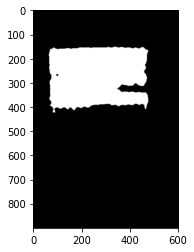

In [205]:
plt.imshow(mapping_resized)

In [190]:
np.unique(mapping_resized)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 18

In [110]:
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray,(15,15),0)
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

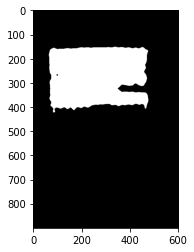

In [111]:
plt.imshow(thresholded_img, cmap="gray")

In [112]:
thresholded_img.ndim

2

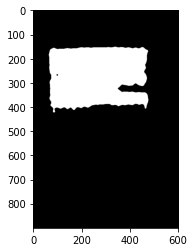

In [113]:
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB)
plt.imshow(mapping)

In [114]:
np.unique(mapping)

array([  0, 255], dtype=uint8)

In [115]:
blurred_original_image = cv2.GaussianBlur(orig_imginal,
                                          (251,251), 
                                          0)

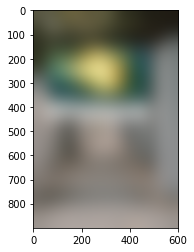

In [116]:
plt.imshow(blurred_original_image)

In [117]:
layered_image = np.where(mapping != (0,0,0), 
                         orig_imginal, 
                         blurred_original_image)

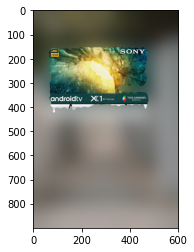

In [118]:
plt.imshow(layered_image)

In [119]:
im_rgb = cv2.cvtColor(layered_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("Potrait_Image.jpg", im_rgb)

True

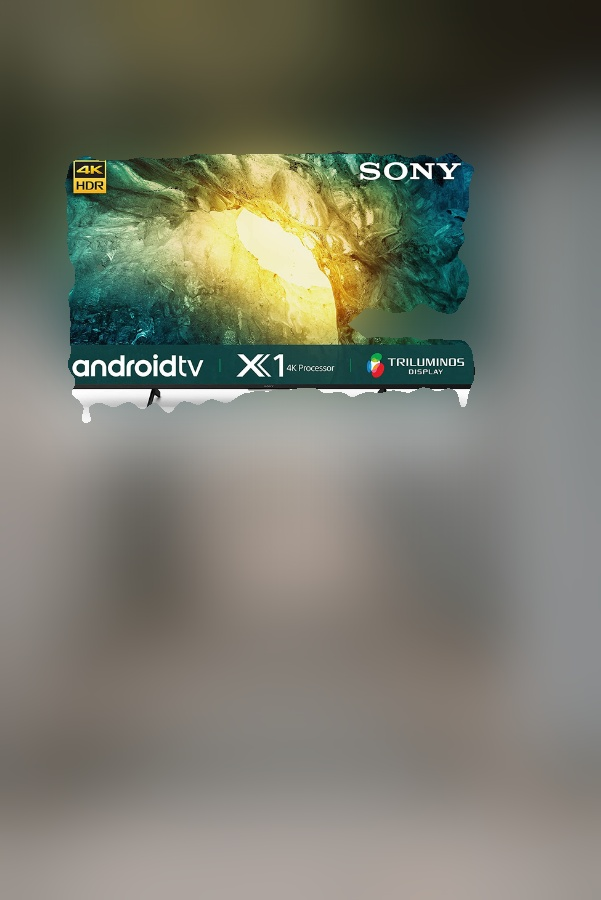

In [120]:
IMG("Potrait_Image.jpg")